# points

> binomial and poisson point process

In [ ]:
#| hide
#| default_exp points

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Literal, Optional
from fastcore.basics import patch
import functools

import numpy as np
from scipy.spatial import ConvexHull

In [ ]:
#|export

def in_hull(point:np.array,  # 1d array 
            hull:ConvexHull, # see scipy.spatial
            tol=1e-9): 
    """checks whether point is inside hull"""
    assert len(point)==hull.ndim, "expect point, hull in the same dimension"
    W,b = hull.equations[:,:-1], hull.equations[:,-1]
    return np.all(W@point+b<=tol)

In [ ]:
#|export
class Points:
    """define binomial or poisson point process in a convex polytope"""
    def __init__(self, n:int, # (expected) number of points 
                d=2,  # dimensionality
                seed: Optional[int]=None, 
                law: Literal["binomial","poisson"]="binomial", # distribution of the points 
                shape: Optional[ConvexHull]=None): # sample from shape, default to unit box
        assert law in ["binomial","poisson"]
        self.rng = np.random.default_rng(seed)
        self.n = self.rng.poisson(n) if law == "poisson" else n
        self.d = d
        self.shape = shape
    
    @functools.cached_property
    def points(self):
        """actually generate points from the prescribed distribution"""
        if self.shape is None: # unit cube
            return self.rng.uniform(size=(self.n,self.d))
        else:
            ps = []
            for _ in range(self.n):
                while True:
                    # must mint new point, no seed passed
                    sample = np.random.default_rng().uniform(self.shape.min_bound, self.shape.max_bound,(self.d,))                     
                    if in_hull(sample, self.shape): ps.append(sample); break
            assert len(ps)==self.n
            return np.array(ps)
        
    @functools.cached_property
    def distance_matrix(self):
        ps = self.points
        diff = ps[:,None,:] - ps[None,:,:]
        dm =  np.linalg.norm(diff,axis=-1)
        return dm

In [ ]:
import matplotlib.pyplot as plt

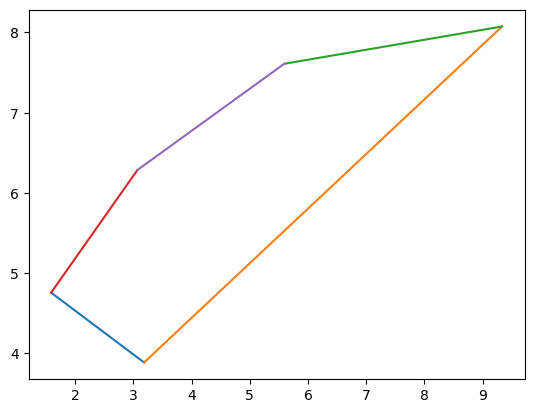

In [ ]:
rng = np.random.default_rng()
vertices = rng.uniform(0,10,size=(5,2))
hull = ConvexHull(vertices)
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

False


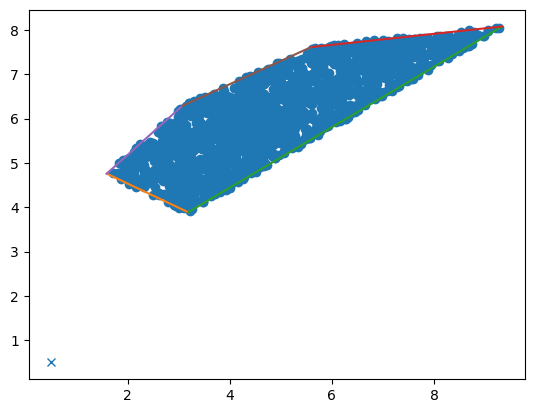

In [ ]:

process = Points(1600,shape=hull)
bin = process.points
p = np.array([0.5,0.5])
print(in_hull(p, hull))
plt.scatter(*bin.T)
plt.plot(*p, 'x')
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

In [ ]:
Points(5,d=3,shape=ConvexHull(np.random.default_rng().uniform(size=(4,3)))).points

array([[0.77855289, 0.4850915 , 0.42972623],
       [0.65133126, 0.45593755, 0.53063587],
       [0.6736211 , 0.67348507, 0.18656676],
       [0.59821495, 0.49935331, 0.47867237],
       [0.63326363, 0.58585142, 0.37836227]])

In [ ]:
#|export

@patch
def lnnl(self:Points,k:int=1):
    """computes largest k-nearest neighbour link"""
    ds = self.distance_matrix
    idx = np.argpartition(ds,k,-1)[:,k] # j-th col of argpartiion gives indices of j-th smallest of each row   
    return ds[np.arange(self.n),idx].max()

In [ ]:
process.lnnl(), process.lnnl(2), process.lnnl(3) 

(0.1465206003726509, 0.23711929766470216, 0.24755948776583622)

In [ ]:
#| export
@patch
def connectivity_threshold(self:Points, output_lnnl=False):
    s = self.rng.choice(self.n)
    component = np.zeros(self.n,dtype=bool)
    component[s]=True
    lnnl = r = self.lnnl()
    dm = self.distance_matrix
    while True:
        # collect vertices within distance r from component
        t =  np.max(dm[component]<=r,axis=0)
        if np.any(t>component): # if discover new things: add them to component
            component[t]=True
            if np.all(component): break
        else: # bfs done, component is a cluster; compute its distance to others 
            r = dm[component][:,~component].min()
    return r if not output_lnnl else (lnnl,r)

In [ ]:
process.connectivity_threshold()

0.1782874408917787

# Coverage

The new method for computing the coverage threshold is a higher-dimensional generalisation of the method of "counting corners".
In two dimensions every vacant region contains a "corner" - the intersection of a _circle_ (boundary of a disc) with either another circle or with the boundary of the polytope. That is, if the radius is large enough that corners exist.

In $d \geq 2$ dimensions, zero-dimensional corners can be formed by the intersection of the boundaries of $d$ balls. Loosely inspired by Bobrowski's definition of "critical faces" in https://doi.org/10.1007/s00440-022-01149-6, we look for "valid" simplices.

A $(d-1)$-dimensional simplex $\sigma$ is formed by $d$ vertices, all of which intersect in a common point. If the vertices are in "general position" (true for iid uniform points) then there is a unique $(d-1)$-dimensional hyperplane passing through all the points. On that plane, there is a unique point which is equidistant from all $d$ vertices, call it $c = c(\sigma)$. (For example, if the simplex is a line segment then $c$ is the midpoint. If the simplex is a triangle then $c$ is the centre of its circumscribed circle.)

If $c(\sigma)$ is in the interior of $\sigma$ (i.e. the open convex hull of its $d$ vertices), then we call $\sigma$ a *valid simplex*.

Not every simplex is valid: if $d=3$ think of a very flat triangle, which will be circumscribed in a circle whose centre is far away. Try adjusting `h` below: the triangle is a valid simplex when `h > 1` but not otherwise.

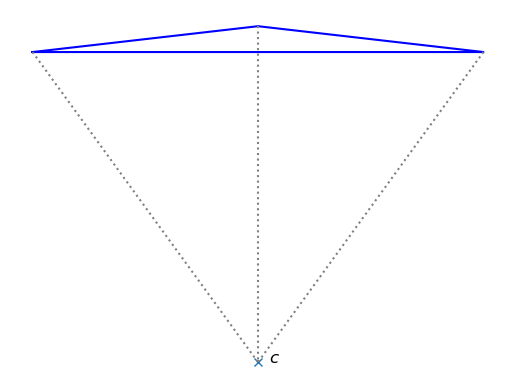

In [ ]:
h = 0.2 # if h is small the triangle is very flat
H = 0.5*(1-h*h)/h
v = np.array([[0,0],[2,0],[1,h],[0,0]])
c = [1,-H]
plt.axis('off')
plt.plot(v[:,0],v[:,1],color='b')
plt.plot(1,-H,'x')
plt.text(1+0.05,-H,'$c$',size=12)
for i in range(3):
    plt.plot([v[i,0],1],[v[i,1],-H],color='gray',linestyle='dotted')

My conjecture is that every vacant region either contains a corner formed by a valid simplex, or touches the boundary of the polytope. I believe this follows from Bobrowski's argument using Morse theory that the homology of the union of balls (in particular the number of uncovered regions which do not intersect the boundary) only changes when critical faces are created or covered.

The corners are then quite easy to deal with: by checking a relatively small number of points we can find out how large $r$ needs to be to ensure the corner is covered.

The boundary is a bit tricky: its intersections with the balls may not form corners.

In [ ]:
#|export
@patch
def get_simplices(self:Points):
    """
    Returns a list of all the (d-1)-dimensional simplices
    in the Cech complex with given Points and with radius r.
    Or perhaps all the "valid" simplices, meaning that the unique point
    in the (d-1)-dimensional hyperplace passing through all d vertices
    which is equidistant to all d vertices
    lies within the simplex itself.
    If this condition isn't met then the set of points which are distance r
    from each of the vertices is either empty or infinite.
    For a valid simplex, on the other hand, there are exactly two such points.

    It should also return the centre, and maybe the normal to the hyperplane passing through the d verticles
    for each valid simplex in the list.
    """
    # First, we choose an r so that the union of balls of radius r/2 covers self.shape.
    # When d=2 we have an upper bound which holds with very high probability
    # that doesn't depend (to first order) on the geometry of the polytope,
    # but in higher dimensions it will. (Penrose "Random Euclidean coverage from within", Thms 3.2 and 3.3)
    # For d>3 we don't even have a formula for the first-order term, although I suspect it will be
    # 2^d times the coverage threshold, for which we do have asymptotics.
    # (Penrose, Yang, Higgs "Largest nearest-neighbour link and connectivity threshold in a polytopal random sample")
    r = self.connectivity_threshold() * 4**self.d # This should hopefully be larger than the coverage threshold with very high probability.
    # Get a list of edges
    mask = self.distance_matrix < r
    return {i: [j for j,v in enumerate(row) if v and j > i] for i,row in enumerate(mask)}
    if self.d == 2:
        # Every edge is valid, so this is simpler. We just need to return the midpoints and normals, but this is also simple.
        pass
    else:
        pass

The important part of the new method is that there is a very simple formula for what radius is needed to cover a given corner.

If $c$ is the unique point which is equidistant to all $d$ points in the valid simplex, and $\rho$ is the distance between $c$ and a vertex,
then the distance between each "corners" and the simplex when the balls have radius $r > \rho$ is $h := \sqrt{r^2 - \rho^2}$.

(-0.4849916708323414, 1.3848250874791697, -0.585, 1.285)

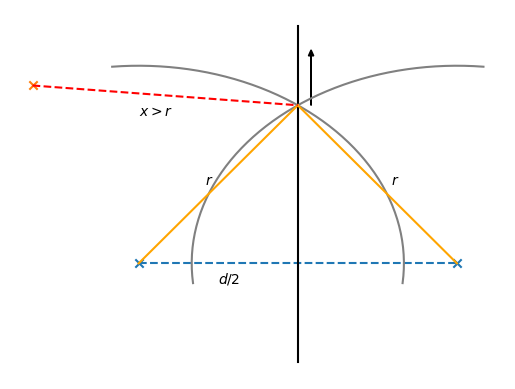

In [ ]:
d=1.2
r=1.0
v1 = np.array([0,0])
v2 = np.array([d,0])
angles = np.linspace(-0.1, 0.5*np.pi+0.1)
circle1x = v1[0] + r*np.cos(angles)
circle1y = v1[1] + r*np.sin(angles)
circle2x = v2[0] - r*np.cos(angles)
circle2y = v2[1] + r*np.sin(angles)
plt.scatter([v1[0],v2[0]],[v1[1],v2[1]],marker='x')
plt.plot([0,d],[0,0],linestyle='dashed')
plt.plot([d/2,d/2],[-0.5*r,1.2*r],color='black')
plt.text(d/4, -0.1, '$d/2$')
plt.plot(circle1x,circle1y,color='gray')
plt.plot(circle2x,circle2y,color='gray')
plt.plot([0,d/2],[0,np.sqrt(r*r - 0.25*d*d)],color='orange')
plt.plot([d,d/2],[0,np.sqrt(r*r - 0.25*d*d)],color='orange')
plt.text(d/4 - 0.05,0.5*np.sqrt(r*r - 0.25*d*d),'$r$')
plt.text(3*d/4 + 0.05,0.5*np.sqrt(r*r - 0.25*d*d),'$r$')
plt.arrow(d/2 + 0.05,np.sqrt(r*r - 0.25*d*d),0,0.25,head_width=0.02,color='black')
plt.scatter(d/2-r,np.sqrt(r*r - 0.25*d*d)+0.1,marker='x')
plt.plot([d/2-r,d/2],[np.sqrt(r*r - 0.25*d*d)+0.1,np.sqrt(r*r - 0.25*d*d)],color='red',linestyle='dashed')
plt.text(d/2 - 0.6*r, np.sqrt(r*r - 0.25*d*d)-0.05, '$x > r$')
plt.axis('off')

For a given valid simplex with an uncovered corner, let the corner be at $v \in \mathbb{R}^d$. Take another point $w$ not in the simplex, at distance $x > r$ from $v$. We'd like to know at what radius $r' > r$ is the corner first covered by $B(w,r')$, but this does not mean just taking $r' = \| v - w \|$ because the corner moves when we change the radius of the balls.

Let $\hat n$ be the (direction of the) normal to the simplex passing through $v$, i.e. $\hat n = \frac{v - c}{\|v-c\|}$. Determining $r'$ is just simple trigonometry. Let $H$ be the height of $w$ above the polytope: $H := (w-c)\cdot \hat n$, and let $W = \sqrt{\|w-c\|^2 - H^2}$.
If we increase the radius of the balls to $r'$, then the distance between the corner $v'$ and $c$ increases to $h' := \sqrt{(r')^2 - \rho^2}$.
Therefore, $r'$ is defined by $(H-h')^2 + W^2 = (r')^2.$

By a simple calculation, we find
$r' = \sqrt{ \rho^2 + \frac{\|w-c\|^2 - \rho^2}{2H} }$.

So if we iterate this over all possible candidates to cover the corner (every $w$ with $w \cdot \hat n > c \cdot \hat n$ and $\| w - v \| \leq R_{\mathrm{max}}$ for some reasonable upper bound $R_{\mathrm{max}}$), then we can increase the radius of the balls to $r'$.
Then we remove this corner from our list of things to check, and we check another corner (either the other corner corresponding to this simplex, or we move to the next valid simplex).

In [ ]:
#|export
@patch
def coverage_threshold(self:Points):
    """
    Finds the coverage threshold: the smallest r such that the union of balls of radius r
    centred at self.points covers self.shape.
    Uses the new method described above.
    """
    if self.d == 2:
        pass
    else:
        pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()